code from five38

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'




In [163]:
weather_data = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/us-weather-history/KSEA.csv', parse_dates=['date'])
print(weather_data.describe())

# explore rain data
rain_cols = ['date']+list(weather_data.columns)[-3:]
rain = weather_data[rain_cols]
# print(rain.info())

# plt.savefig('{}.png'.format(column))
# how does rain deviate from historical average over the year?
rain['Excess Rainfall'] = rain['actual_precipitation'] - rain['average_precipitation']
# cumulative rainfall relative to year
rain['Cumulative Excess Rainfall'] = rain['Excess Rainfall'].cumsum()
# how does rainfall change from month to month?
rain['month'] = rain['date'].dt.month
# rain.groupby('month').agg({'actual_precipitation': 'mean',
#                            'actual_precipitation': 'std',
#                            'average_precipitation': 'mean'})
# need to sort month from july to june:
m_order = [7, 8, 9, 10, 11, 12, 1 , 2, 3, 4, 5, 6]
rain['month'] = pd.Categorical(rain['month'], ordered=True, categories=m_order)

       actual_mean_temp  ...  record_precipitation
count        365.000000  ...            365.000000
mean          56.542466  ...              1.107178
std           10.437226  ...              0.648280
min           30.000000  ...              0.110000
25%           49.000000  ...              0.660000
50%           56.000000  ...              0.960000
75%           65.000000  ...              1.410000
max           80.000000  ...              5.020000

[8 rows x 12 columns]


Text(0.5, 1.0, 'record_precipitation')

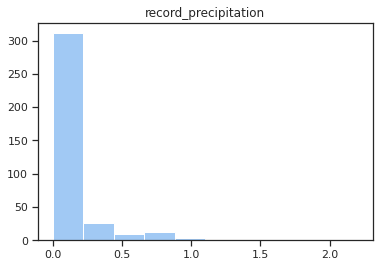

In [169]:
plt.figure()
plt.hist(weather_data['actual_precipitation'].values)
plt.title(column)


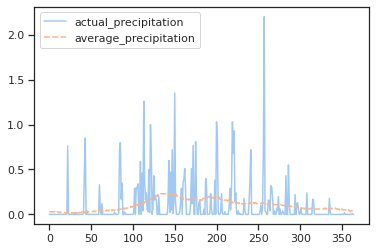

In [174]:
sns.lineplot(data = rain.iloc[:, :3])

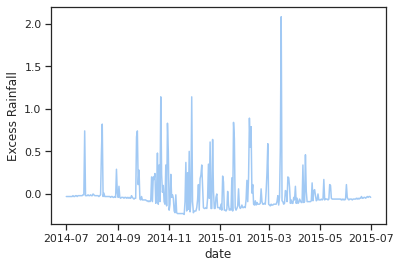

In [176]:
sns.lineplot(y='Excess Rainfall', x='date', data = rain)

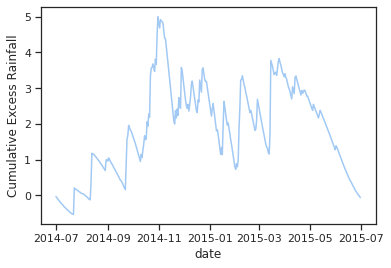

In [168]:

sns.lineplot(y='Cumulative Excess Rainfall', x='date', data = rain)

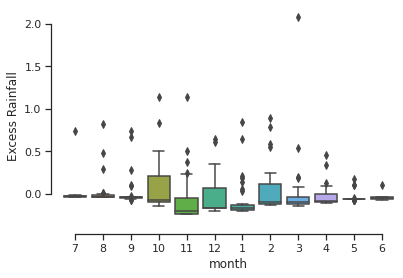

In [161]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# draw boxplot
sns.boxplot(x="month", y="Excess Rainfall",
            data=rain)
sns.despine(offset=10, trim=True)

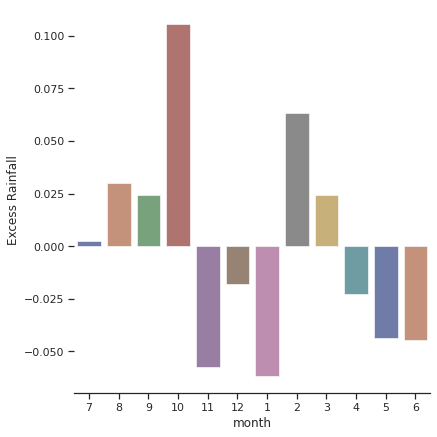

In [162]:
# Draw a rainfall barplot by month
g = sns.catplot(
    data=rain, kind="bar",
    x="month", y="Excess Rainfall",
    ci=None, 
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)

In [141]:
# define drought as n-day streak with rainfalls of p or lower
# report the drought periods
p = 0.1
rain['drought'] = rain['actual_precipitation'] < p
rain['grouper'] = (rain.drought != rain.drought.shift()).cumsum()
rain['streak'] = rain['drought'].groupby(grouper).cumsum()
rain.head(10)
for i, g in rain.groupby('grouper'):
    if len(g.date.tolist()) >20:
      print ("First day of dought: {}. Drought duration: {}".format(g.date.tolist()[0],len(g.date.tolist())))
      print("Average rain per day: {}. Total accumulation: {}".format(round(g.actual_precipitation.mean(), 3), round(g.actual_precipitation.sum(),3)))

First day of dought: 2014-07-01 00:00:00. Drought duration: 22
Average rain per day: 0.0. Total accumulation: 0.01
First day of dought: 2015-06-02 00:00:00. Drought duration: 29
Average rain per day: 0.002. Total accumulation: 0.05
